# Analysis on predictive models for daily stock volume


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime

from ipywidgets import IntProgress
from IPython.display import Markdown as md, display, Math, Latex


# NOTE - modify when pkg destination changed
from models.volume.core import ADV, MDV

_RUN_DATE = datetime.utcnow().date()
_VOLUME_FILE = "/home/cnoble/Documents/market_data/volume/snp_500_2022-08-29-20-Y.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.max_colwidth", None)

# TODO - SPLIT DATA SETS


## Abstract

The goal of this paper is to reproduce the *ARMA daily forecasting model* presented in Algorithmic Trading Methods - Kissel and compare it's performance against the standard ADV30 measure for predicting daily volumes.

## Lexicon

$ADV(n)$: Average Daily Volume of $n$ day rolling window

$MDV(n)$: Median Daily Volume of $n$ day rolling window

## Analysis goals

1. Calculate $ADV(n)$ and $MDV(n)$ across a range of horizon hyperparameters. Evaluate predictive performance and select the best for:

    a. A baseline predictor for daily volume
    
    b. Input for more ARMA model
    
2. Discuss ARMA model and input variables

3. Fit and compare ARMA model to 'best' simplistic baseline from Step 1.

## Data
    
### Universe
    
S&P 500 stocks (as of {_RUN_DATE})

### Daily volumes
    
20 year (as of {_RUN_DATE}) look back of daily consolidated volumes obtained from the Interactive Brokers TWS API. Consolidated volume is extracted from the 'SMART' exchange provided by IB, this is effectively all volume available to the IB smart order router and is (according to IB) their best available volume measure.

**Note: No trading phases are resolved and it is assumed that the daily measures include auction volume**)

**Note: All data (with full window to support lagged metrics) are included**

### Train/Test/Validate split

80/10/10% split will be used when fitting the ARMA model. Rolling windows will be compeletely segregated with no overlap in data

**TODO: how to improve / analyze shifts in market behaviour?**
        

## Step 1: ADV and MDV analysis

1. Calculating $ADV(n)$, $MDV(n)$ for $n \in [1:50]$
2. Compute percentage error for each metric and view mean and std-dev percentage error for each stock
3. Select appropriate metric base on the error profiles

**NOTE: We use standard percentage error calculation not log ratio... Log derived percentage error is only valid for small deviations and we expect volume estimate errors to be large here, >> %5 (the point at which ln(Vt/Vt-1) diverges from ((Vt - Vt-1) / Vt-1). As a result we do not make any adjustments for the effect of volume / mkt cap as discussed in the text** 

In [2]:
# load volume data
volume = pd.read_csv(_VOLUME_FILE).set_index("date")

# fix volume data
# TODO - put in data load
volume = volume.replace(0.0, np.nan)

# remove partial day
volume = volume[volume.index != "2022-08-29"]

max_window = 50

results = list()
f = IntProgress(min=0, max=max_window-1) # instantiate the bar
display(f)

for window in range(1, max_window):

    # calculate ADV and MDV for window
    adv = ADV(volume, window)
    mdv = MDV(volume, window)

    # calculate %ge error
    # TODO - is ln(adv / vol) valid given large deviations?
    # TODO - think of different way to normalize affect of volume across stocks.
    
    # adv_err = np.log(adv / volume)
    # mdv_err = np.log(mdv / volume)   
    adv_err = (adv - volume) / volume
    mdv_err = (mdv - volume) / volume
    
    # calculate stock level first and second moments, then average over stocks
    adv_mean_err = adv_err.mean().mean()
    adv_std_err = adv_err.std().mean()
    mdv_mean_err = mdv_err.mean().mean()
    mdv_std_err = mdv_err.std().mean()
    

    results.append([window, adv_mean_err, adv_std_err, mdv_mean_err, mdv_std_err])

    f.value += 1
    
err = pd.DataFrame(results, columns=["window", "adv_mu", "adv_sig", "mdv_mu", "mdv_sig"])

IntProgress(value=0, max=49)

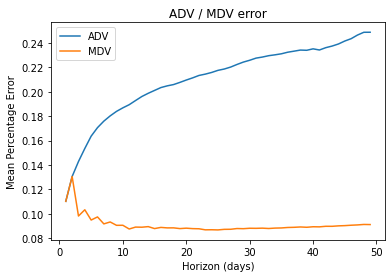

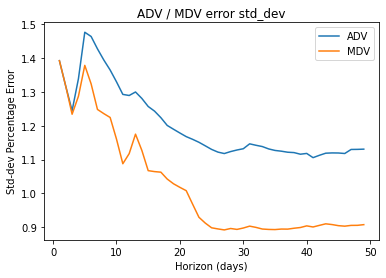

In [3]:
# Plot error for ADV and MDV metrics over the horizons

plt.plot(err["window"], err[["adv_mu", "mdv_mu"]])
plt.title("ADV / MDV error")
plt.xlabel("Horizon (days)")
plt.ylabel("Mean Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

plt.plot(err["window"], err[["adv_sig", "mdv_sig"]])
plt.title("ADV / MDV error std_dev")
plt.xlabel("Horizon (days)")
plt.ylabel("Std-dev Percentage Error")
plt.legend(["ADV", "MDV"])
plt.show()

## Analysis

1. We can see that MDV appears to converge on around 9% mean error whereas ADV error seems to increase with horizon. Likely this is due to outliers adversely affecting ADV (and the longer horizon increases likelihood window contains an outlier).
2. The std-dev error converges for both metrics at around 25 days. MDV converges to a lower std-dev. 25 days is an interesting value as this corresponds to just over a month of trading days...

# TODO - START HERE

Plot MAE, MSE, R^2 etc for each and compare

This simple analysis supports use of $MDV(25)$ as a reasonable statistic for use in steps 2 & 3

## Step 2: ARMA model

The ARMA model is defined as:

$\hat{V}_t = \bar{V}_{t-1} . D_t + \hat{\beta} . e_{t-1}$

Where:

$\hat{V}_t$ = forecast volume on day t

$\bar{V}_{t-1}$ = $MDV(25)$ selected base volume metric from Step 1.

$D_t$ = day of week adjustment metric

$e_{t-1}$ = Previous days forecast error ($V_{t-1} - \hat{V}_{t-1}$)

$\hat{\beta}$ = Auto-regressive sensitivity parameter - esimated by OLS regression

Rationale is as follows:

1. We use a stable measure of contemporary historical volume MDV(25) on which to base our estimate
2. We believe weekly trade volume is cyclical (weekly) thus add another variable here to adjust MVD(25) on this basis
2. We add an auto-regressive term to capture persistent excess volume across days


### Calculating $D_T$

Our goal here is to determine what (if any) cyclical relationships there are across weekdays.

1. Calculate the deviation of daily trading volumes from their (lagged) weekly average across stocks
2. Average across stocks for each day

We see that there is a hump mid-week with the lowest volume day being Monday... This is in disagreement with the text but we'll proceed on this basis for the time being

In [4]:
# calculate cyclical week day volumes

# TODO - make sure to use train dataset!

calendar = pd.to_datetime(volume.index).isocalendar()
week_keys = calendar.year * 100 + calendar.week

date_week = volume.copy()
date_week["week_key"] = week_keys
date_week = date_week["week_key"].reset_index()

week_volume = volume.copy()
week_volume["week_key"] = week_keys
week_volume = week_volume.groupby("week_key", as_index=False).mean()
week_volume = date_week.merge(week_volume, how="left", left_on="week_key", right_on="week_key").set_index("date").drop("week_key", axis=1)

pct_volume = volume / week_volume
weekday_pct_volume = pct_volume.groupby([calendar.day]).mean().mean(axis=1)

Text(0.5, 0, 'Weekday')

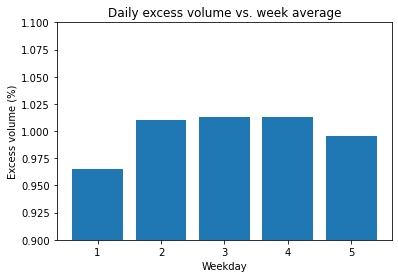

In [17]:
plt.bar(weekday_pct_volume.index, weekday_pct_volume.values)
plt.ylim([0.9, 1.1])
plt.title("Daily excess volume vs. week average") 
plt.ylabel("Excess volume (%)")
plt.xlabel("Weekday")

In [ ]:
# Fit the model

# Discuss regression metrics / coeffs

# Analyse regression / performance metrics vs. ADV30, MDV25 
# Outlier investigation - further work on triple witching etc.

## Environment

In [6]:
text=f"""
### UTC date:[{datetime.utcnow()}]
### Conda environment:[POPULATE!]
"""

In [7]:
# TODO

## 1. Analyze different date ranges